# Generating the Models Used in the Binary Classification Example

----
# Overview

## About
This notebook supplements the [Binary Classification Assessment Template Example.ipynb](../tutorials_and_examples/ Example-BinaryClassificationTemplate.ipynb) to provide a more detailed example of how someone might generate and compare an assortment of models for their fairnes and performance.

For this test, only "in-processing" fairness-aware approaches were considered.


## Notebook Contents

[Part 1](#part1) - Data and Analysis

[Part 2](#part2) - Length of Stay Models 

&nbsp;&nbsp;&nbsp;&nbsp;[Part 2.1](#part2.1) - Out-of-the-Box Models

&nbsp;&nbsp;&nbsp;&nbsp;[Part 2.2](#part2.2) - AIF360 Fairness-Aware (In-Process) Models

&nbsp;&nbsp;&nbsp;&nbsp;[Part 2.3](#part2.3) - Fairlearn Fairness-Aware (In-Process) Models

&nbsp;&nbsp;&nbsp;&nbsp;[Part 2.4](#part2.4) - Other Methods

[Part 3](#part3) - Comparing Models
    Includes the fairMLHealth model comparison tool, as well as an example of the Fairlearn Dashboard.

[Part 4](#part4) - Save Results

## Requirements

To run this notebook, please install FairMLHealth using [the instructions posted in GitHub](https://github.com/KenSciResearch/fairMLHealth#installation_instructions). Some components of this notebook additionally require the [Fairlearn](https://github.com/fairlearn/fairlearn) and **tensorflow** packages.

The tutorial uses data from the MIMIC III Critical Care database, a freely accessible source of electronic health records from Beth Israel Deaconess Medical Center in Boston. To download the MIMIC III data, please use this link: [Access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/) and save the data with the default directory name ("MIMIC"). No further action is required beyond remembering the download location, and you do not need to unzip any files.

A basic knowledge of ML implementation in Python is assumed. 


In [1]:
# Standard imports
from IPython.display import Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metric

# Custom imports
from fairmlhealth.mimic_data import load_mimic3_example
from fairmlhealth import reports, tutorial_helpers as helpers, model_comparison as fhmc

# Verify that additonal required packages are present (packages will be loaded later in the notebook)
from fairmlhealth.utils import validate_notebook_requirements
validate_notebook_requirements()

In [2]:
import warnings
#warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore', module='tensorflow')

## Custom Functions


### Custom AIF360 Measurement <a id="custom_aif"></a>
As the fairness-mitigating algorithms available in AIF360 require use of the library's custom data object, the KenSci team developed a custom, AIF360-specific function that outputs a fairness comparison table similar to the one available in fairMLHealth.reports. This function was heavily based in code available in the AIF360 tool itself, and is defined in the cell below.

In [3]:
from collections import defaultdict
from aif360.metrics import ClassificationMetric

def aif_dataset_measures(dataset, models):
    """ Returns a dataframe containing fairness measures for regression 
            models based on the AIF360 library
        Note: function is based heavily on test_thresholds function from
            the AIF360 tutorial
    
    """
    if not isinstance(models, (list, dict)):
        models = [models]
    if not isinstance(models, dict):
        models = {f'model_{i}': m for i,m in enumerate(models)}
    
    #
    sens_ind = 0
    sens_attr = dataset.protected_attribute_names[sens_ind]
    unprivileged_groups = [{sens_attr: v} for v in
                       dataset.unprivileged_protected_attributes[sens_ind]]
    privileged_groups = [{sens_attr: v} for v in
                     dataset.privileged_protected_attributes[sens_ind]]
    #
    metric_dict = defaultdict(list)
    for name, model in models.items():
        y_pred = model.predict(dataset).labels
        dataset_pred = dataset.copy()
        dataset_pred.labels = y_pred
        metric = ClassificationMetric(
                    dataset, dataset_pred,
                    unprivileged_groups =unprivileged_groups,
                    privileged_groups =privileged_groups)
        
        metric_dict['Disparate Impact Ratio'].append(
            metric.disparate_impact())
        metric_dict['Statistical Parity Difference'].append(
            metric.statistical_parity_difference())
        metric_dict['Average Odds Difference'].append(
            metric.average_odds_difference())
        metric_dict['Equal Opportunity Difference'].append(
            metric.equal_opportunity_difference())
        metric_dict['Balanced Accuracy Difference'].append(
            (metric.true_positive_rate() + metric.true_negative_rate()) / 2)
        metric_dict['Between-Group Coefficient of Variation'].append(
            metric.between_group_coefficient_of_variation())
        metric_dict['Theil Index'].append(
            metric.theil_index())
    
    results = pd.DataFrame().from_dict(metric_dict).transpose()
    results.columns = models.keys()
    return(results)


~/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
~/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
~/anaconda3/envs/fairMLHealth/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
~/anaconda3/envs/fairMLHealth/lib/python

### Time Checker

Below we define a simple timer so that we can display compute times for each model.

In [4]:
import datetime

def check_time(start_time = None):
    """ 
    Args:
        start_time (datetime object, optional): If not None, check_time 
            returns the difference between start_time and the current 
            datetime. Otherwise, check_time returns the current datetime. 
            Defaults to None.

    Returns:
        A datetime object.  
    """
    if start_time is not None:
        elapsed_time = datetime.datetime.now() - start_time
        rprt = f"{elapsed_time} (hr:mn:sc)"
        return rprt
        return elapsed_time
    else:
        return datetime.datetime.now()

start_time = check_time()
check_time(start_time)

'0:00:00.000028 (hr:mn:sc)'

----
# Part 1 - Data and Analysis <a class = "anchor" id = "part1"></a>


## MIMIC-III

This example uses a data subset from the [MIMIC-III clinical database](https://mimic.physionet.org/gettingstarted/access/) to predict "length of stay" (LOS) value. For this example, LOS is total ICU time for a given hospital admission in patients 65 and above. The raw LOS value is then converted to a binary value specifying whether an admission's length of stay is greater than the sample mean. 

Note that the code below will automatically unzip and format all necessary data for these experiments from a raw download of MIMIC-III data (saving the formatted data in the same MIMIC folder). MIMIC-III is a freely available database, however all users must pass a quick human subjects certification course. If you would like to run this example on your own, [follow these steps to be granted access to MIMIC III](https://mimic.physionet.org/gettingstarted/access/) and download the data.


In [5]:
# path_to_mimic_data_folder = "[path to your downloaded data folder]"
path_to_mimic_data_folder = "~/data/MIMIC"

## Data Subset <a id="datasubset"></a>

Example models in this notebook use data from all years of the MIMIC-III dataset for patients aged 65 and older. Data are imported at the encounter level with all additional patient identification dropped. All models include an "AGE" feature, simplified to 5-year bins, as well as Boolean diagnosis and procedure features categorized through the Clinical Classifications Software system ([HCUP](https://www.hcup-us.ahrq.gov/toolssoftware/ccs/ccs.jsp)). All features other than age are one-hot encoded and prefixed with their variable type (e.g. "GENDER_", "ETHNICITY_").  

In [6]:
# Load data and keep a 10K observation subset to speed processing
df = load_mimic3_example(path_to_mimic_data_folder) 
df = df.sample(n=10000, random_state=42)

# Subset to ages 65+
df = df.loc[df['AGE'].ge(65), :]
df.drop('GENDER_F', axis=1, inplace=True) # Redundant with GENDER_M

# Display insights
helpers.print_feature_table(df)
display(Markdown('---'))
display(df.head())


 This data subset has 22434 total observations and 648 input features 



,Raw Feature,Category Count (Encoded Features)
0,AGE,1
1,DIAGNOSIS,282
2,ETHNICITY,41
3,GENDER,1
4,INSURANCE,5
5,LANGUAGE,69
6,MARRIED,7
7,PROCEDURE,222
8,RELIGION,20


---

,ADMIT_ID,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,...,PROCEDURE_CCS_222,PROCEDURE_CCS_223,PROCEDURE_CCS_224,PROCEDURE_CCS_225,PROCEDURE_CCS_226,PROCEDURE_CCS_227,PROCEDURE_CCS_228,PROCEDURE_CCS_229,PROCEDURE_CCS_231,length_of_stay
0,1074323,65.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.144444
1,1061231,70.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,5.496528
2,1033329,75.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6.768056
5,1106669,70.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,6.988889
7,1071577,75.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,5.364583


,count,mean,std,min,25%,50%,75%,max
length_of_stay,22434.000000,9.115200,6.208700,0.004200,4.735200,7.579900,12.017700,29.988900
long_los,22434.000000,0.388000,0.487300,0.000000,0.000000,0.000000,1.000000,1.000000


---

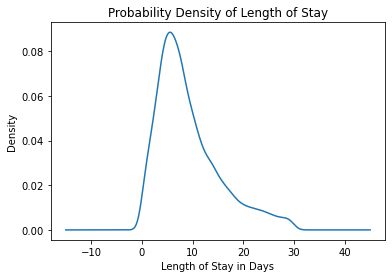

In [7]:
# Generate a binary target flagging whether an observation's length_of_stay value is above or below the mean. 
mean_val = df['length_of_stay'].mean()
df['long_los'] = df['length_of_stay'].apply(lambda x: 1 if x > mean_val else 0)
los_tbl = df[['length_of_stay', 'long_los']].describe().transpose().round(4)
display(los_tbl.style.applymap(helpers.highlight_col, subset = pd.IndexSlice[:, 'mean']))

# Display LOS distributions
display(Markdown('---'))
ax = df['length_of_stay'].plot(kind='kde', title="Probability Density of Length of Stay")
ax.set_xlabel("Length of Stay in Days")
plt.show()

## Split Data

In [8]:
from sklearn.model_selection import train_test_split

# Subset and Split Data
X = df.loc[:, [c for c in df.columns if c not in ['ADMIT_ID','length_of_stay', 'long_los']]]
y = df.loc[:, ['long_los']]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)


In [9]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(15030, 648) (15030, 1) (7404, 648) (7404, 1)


----
# Part 2 - Length of Stay Models <a class = "anchor" id = "part2"></a>

In [10]:
targs = ['LOS > mean', 'LOS <= mean']

### Baseline - Random Sampling

In [11]:
import random

# generate "predictions" as random sample of target values
y = df['long_los']
pos_weight = y.mean()
weights = [1-pos_weight, pos_weight]
values = list(set(y))
y_pred_baseline = np.array(random.choices(values, weights, k=df.shape[0]))
y_prob_baseline = y_pred_baseline

# display baseline performance 
print("\n", "Prediction Scores for Random Sampling:", "\n",
          sk_metric.classification_report(y, y_pred_baseline, target_names=targs)
      )
      


 Prediction Scores for Random Sampling: 
               precision    recall  f1-score   support

  LOS > mean       0.61      0.61      0.61     13730
 LOS <= mean       0.39      0.39      0.39      8704

    accuracy                           0.52     22434
   macro avg       0.50      0.50      0.50     22434
weighted avg       0.52      0.52      0.52     22434





# Part 2.1 - Out-of-the-Box Models <a class = "anchor" id = "part2.1"></a>

### Naive Bayes Classifier

In [12]:
from sklearn.naive_bayes import BernoulliNB

In [13]:
nb_params = {'alpha': 20, 'fit_prior': True}

# Train Model
start_time = check_time()
nb_model = BernoulliNB(**nb_params)
nb_model.fit(X_train, y_train.iloc[:, 0])
y_pred_nb = nb_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Naive Bayes Prediction Scores:", "\n", 
          sk_metric.classification_report(y_test, y_pred_nb, target_names=targs)
      )
      

Model finished in 0:00:00.399715 (hr:mn:sc)

 Naive Bayes Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.76      0.85      0.80      4531
 LOS <= mean       0.71      0.58      0.64      2873

    accuracy                           0.75      7404
   macro avg       0.74      0.72      0.72      7404
weighted avg       0.74      0.75      0.74      7404



### Decision Tree Model

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
dt_params = {'min_samples_split': 10, 'min_samples_leaf': 2,
             'max_depth': 10, 'criterion': 'entropy'}

# Train Model
start_time = check_time()
dt_model = DecisionTreeClassifier(**dt_params)
dt_model.fit(X_train, y_train.iloc[:, 0])
y_pred_dt = dt_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Decision Tree Prediction Scores:", "\n", 
          sk_metric.classification_report(y_test, y_pred_dt, target_names=targs)
      )
      

Model finished in 0:00:00.485999 (hr:mn:sc)

 Decision Tree Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.74      0.85      0.79      4531
 LOS <= mean       0.69      0.52      0.59      2873

    accuracy                           0.72      7404
   macro avg       0.71      0.68      0.69      7404
weighted avg       0.72      0.72      0.71      7404



### Random Forest Model

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
rf_params = {'criterion': 'entropy', 'n_estimators': 1800, 
             'min_samples_split': 5, 'bootstrap': False}

# Train Model
start_time = check_time()
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X_train, y_train.iloc[:, 0])
y_pred_rf = rf_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Random Forest Prediction Scores:", "\n", 
          sk_metric.classification_report(y_test, y_pred_rf, target_names=targs)
      )
      

Model finished in 0:02:39.408150 (hr:mn:sc)

 Random Forest Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.77      0.90      0.83      4531
 LOS <= mean       0.78      0.57      0.66      2873

    accuracy                           0.77      7404
   macro avg       0.77      0.73      0.74      7404
weighted avg       0.77      0.77      0.76      7404



### Logistic Regression Model

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lr_params = {'penalty': "none", 'max_iter': 10**4}

# Train Model
start_time = check_time()
lr_model = LogisticRegression(**lr_params)
lr_model.fit(X_train, y_train.iloc[:, 0])
y_pred_lr = lr_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Logit Regression Prediction Scores:", "\n", 
        sk_metric.classification_report(y_test, y_pred_lr, 
                                        target_names=targs, zero_division=0)
      )
      

Model finished in 0:00:21.273132 (hr:mn:sc)

 Logit Regression Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.79      0.87      0.83      4531
 LOS <= mean       0.75      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.77      0.75      0.76      7404
weighted avg       0.77      0.78      0.77      7404



### SVM Model

In [20]:
from sklearn.svm import LinearSVC 
import warnings
warnings.filterwarnings('ignore', message="Liblinear failed to converge, increase the number of iterations.")

In [21]:
svm_params = {'max_iter': 10**4}

# Train Model
start_time = check_time()
svm_model = LinearSVC(**svm_params)
svm_model.fit(X_train, y_train.iloc[:, 0])
y_pred_svm = svm_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "SVM Prediction Scores:", "\n", 
        sk_metric.classification_report(y_test, y_pred_svm,
                                        target_names=targs, zero_division=0) 
      )

Model finished in 0:00:16.500005 (hr:mn:sc)

 SVM Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.81      0.83      0.82      4531
 LOS <= mean       0.72      0.69      0.71      2873

    accuracy                           0.78      7404
   macro avg       0.76      0.76      0.76      7404
weighted avg       0.77      0.78      0.77      7404



### LightGBM

In [22]:
import lightgbm as lgb

In [23]:
lgb_params = {'objective': 'binary', 'metric': 'auc', 
              'learning_rate': 0.03, 'num_leaves': 10,
              'max_depth': 3}

start_time = check_time()
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(X_train, y_train.iloc[:, 0])
y_pred_lgb = lgb_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
        sk_metric.classification_report(y_test, y_pred_lgb, target_names=targs)
      )
      

Model finished in 0:00:00.367544 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.73      0.91      0.81      4531
 LOS <= mean       0.76      0.47      0.58      2873

    accuracy                           0.74      7404
   macro avg       0.74      0.69      0.69      7404
weighted avg       0.74      0.74      0.72      7404



### XGBOOST Model

In [24]:
from xgboost import XGBClassifier

In [25]:
xgb_params = {'colsample_bytree': 1.0, 'gamma': 2, 
              'learning_rate': 0.05, 'max_depth': 5, 
              'min_child_weight': 1,  'n_estimators': 600, 
              'subsample': 0.6
             }

# Train Model
xgb_model = XGBClassifier(**xgb_params)
start_time = check_time()
xgb_model.fit(X_train, y_train.iloc[:, 0])
y_pred_xgb = xgb_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
        sk_metric.classification_report(y_test, y_pred_xgb, target_names=targs)
      )
      

Model finished in 0:01:53.662104 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.79      0.88      0.83      4531
 LOS <= mean       0.77      0.63      0.70      2873

    accuracy                           0.78      7404
   macro avg       0.78      0.76      0.76      7404
weighted avg       0.78      0.78      0.78      7404





# Part 2.2 - AIF360 Fairness-Aware  (In-Process) Models <a class = "anchor" id = "part2.2"></a>

Reference: [AIF360 Inprocessing Algorithms](https://aif360.readthedocs.io/en/latest/modules/algorithms.html#module-aif360.algorithms.inprocessing)

### Data Preparation

As noted [above](#custom_aif), the fairness-mitigating algorithms available in AIF360 require use of the library's custom data object. In the cells that follow we will attach our split data to one of those objects.

In [26]:
import aif360.datasets as aifdata

In [27]:
test_data = pd.concat([X_test, y_test], axis=1)
train_data = pd.concat([X_train, y_train], axis=1)
df = pd.concat([test_data, train_data], ignore_index=True)
df.head()


,AGE,GENDER_M,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE,ETHNICITY_AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE,ETHNICITY_ASIAN,ETHNICITY_ASIAN - ASIAN INDIAN,ETHNICITY_ASIAN - CAMBODIAN,ETHNICITY_ASIAN - CHINESE,ETHNICITY_ASIAN - FILIPINO,ETHNICITY_ASIAN - JAPANESE,...,PROCEDURE_CCS_222,PROCEDURE_CCS_223,PROCEDURE_CCS_224,PROCEDURE_CCS_225,PROCEDURE_CCS_226,PROCEDURE_CCS_227,PROCEDURE_CCS_228,PROCEDURE_CCS_229,PROCEDURE_CCS_231,long_los
0,80.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,80.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,65.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,75.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:

aif_data = pd.concat([X, y], axis=1)
los_dataset = aifdata.StandardDataset(df=aif_data, 
                                      label_name='long_los',
                                      favorable_classes=[1],
                                      instance_weights_name=None,
                                      categorical_features=['AGE'],
                                      protected_attribute_names=['LANGUAGE_ENGL'],       
                                      privileged_classes=[[1]],                   
                                      custom_preprocessing=None
                                      )
                         

### GerryFair Classifier

Theoretically a predictor can be set, but valid argument could not be found during testing. Per the documentation: "predictor: Hypothesis class for the Learner. Supports LR, SVM, KR, Trees"

Reference: [Kearns, Neel, Roth, Wu, 2018](https://arxiv.org/abs/1711.05144)

In [29]:
from aif360.algorithms.inprocessing import GerryFairClassifier

In [30]:
gf_params = {'fairness_def': "FN", 'C': 100,
             'printflag': True, 'gamma': 0.005,
             'max_iters': 500, 'heatmapflag': False}

start_time = check_time()
aif_gf_model = GerryFairClassifier(**gf_params)
aif_gf_model.fit(los_dataset, early_termination=True)
yhat_aifgf = aif_gf_model.predict(los_dataset, threshold=False)
print("Model finished in", check_time(start_time))


iteration: 1, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
iteration: 2, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
iteration: 3, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
iteration: 4, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
iteration: 5, error: 0.20986003387715074, fairness violation: 0.0036408985147281703, violated group size: 0.1964428991709013
Model finished in 0:00:17.519050 (hr:mn:sc)


### Prejudice Remover Regularizer

Reference: [Kamishima et al., 2012](https://rd.springer.com/chapter/10.1007/978-3-642-33486-3_3)

In [31]:
from aif360.algorithms.inprocessing import prejudice_remover

In [32]:
pr_params = {'sensitive_attr': "LANGUAGE_ENGL"}

start_time = check_time()
aif_prr_model = prejudice_remover.PrejudiceRemover(**pr_params)
aif_prr_model.fit(los_dataset)
yhat_aif_prr = aif_prr_model.predict(los_dataset)
print("Model finished in", check_time(start_time))


Model finished in 0:01:32.119658 (hr:mn:sc)


### Adversarial Debiasing

Reference: [Zhang et al., 2018](https://arxiv.org/abs/1801.07593)

In [33]:
from aif360.algorithms.inprocessing import adversarial_debiasing


In [34]:
from distutils.version import StrictVersion

run_adb = False
try:
    import tensorflow as tf
    if StrictVersion(tf.__version__) >= StrictVersion('2.0.0'):
        print(f"ALERT: Current adversarial debiasing method may not be compatible with your version of tensorflow ({tf.__version__}).",
            "Skipping this model.")
    else:
        run_adb = True
        print("Tensorflow Version Check: passed. Current adversarial debiasing method is likely to work with your version of tensorflow.")
except BaseException as e:
    print(e)
    pass

Tensorflow Version Check: passed. Current adversarial debiasing method is likely to work with your version of tensorflow.


In [35]:
if run_adb:
    sess = tf.compat.v1.Session()

    adb_params = {'privileged_groups': [{'LANGUAGE_ENGL': 1}],
                  'unprivileged_groups': [{'LANGUAGE_ENGL': 0}],
                  'scope_name': 'plain_classifier',
                  'debias': False,
                  'sess': sess}

    start_time = check_time()
    aif_adb_model = adversarial_debiasing.AdversarialDebiasing(**adb_params)
    aif_adb_model.fit(los_dataset)
    yhat_aifadb = aif_adb_model.predict(los_dataset)
    print("Model finished in", check_time(start_time))
else:
    aif_adb_model = None
    yhat_aifadb = np.zeros(len(y_test))




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




epoch 0; iter: 0; batch classifier loss: 0.690905
epoch 1; iter: 0; batch classifier loss: 0.474774
epoch 2; iter: 0; batch classifier loss: 0.323571
epoch 3; iter: 0; batch classifier loss: 0.382452
epoch 4; iter: 0; batch classifier loss: 0.340088
epoch 5; iter: 0; batch classifier loss: 0.324173
epoch 6; iter: 0; batch classifier loss: 0.351611
epoch 7; iter: 0; batch classifier loss: 0.419504
epoch 8; iter: 0; ba

### Other AIF360 Fairness-Aware Options that are Not Yet Working for Us

In [36]:
from aif360.algorithms.inprocessing import meta_fair_classifier

In [37]:
mf_params = {'sensitive_attr': "LANGUAGE_ENGL"}
aif_mfc_model = meta_fair_classifier.MetaFairClassifier(**mf_params)
#aif_mfc_model.fit(los_dataset)
#yhat_aifmfc = aif_mfc_model.predict(los_dataset)
print("meta_fair_classifier failed to converge in testing")


meta_fair_classifier failed to converge in testing




# Part 2.3 - Fairlearn Fairness-Aware  (In-Process) Models <a class = "anchor" id = "part2.3"></a>

In [38]:
from fairlearn.reductions import GridSearch, ExponentiatedGradient
from fairlearn.reductions import EqualizedOdds, DemographicParity 


## -- Fair GridSearch --

Fairlearn's GridSearch is a wrapper that runs a constrained optimization using the Grid Search approach  on a binary classification or a regression model. It treats the prediction as a sequence of cost-sensitive classification problems, returning the solution with the smallest error (constrained by the metric of choice). This approach has been demonstrated to have minimal effect on model performance by some measures [[Agarwal *et al* (2018)]](#ref).

This approach is applicable to sensitive attributes that are binary/Boolean only. It can be used for either binary classification or regression problems.


### Fair GridSearch on LGBM - Constrained by Equalized Odds

In [39]:
# Train GridSearch
gs_lgb_model = GridSearch(lgb.LGBMClassifier(**lgb_params),
                           constraints=EqualizedOdds(),
                           grid_size=45)

start_time = check_time()
gs_lgb_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_gs_lgb = gs_lgb_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_gs_lgb, 
            target_names=targs)
      )
      

Model finished in 0:00:50.297170 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.73      0.91      0.81      4531
 LOS <= mean       0.76      0.47      0.58      2873

    accuracy                           0.74      7404
   macro avg       0.74      0.69      0.69      7404
weighted avg       0.74      0.74      0.72      7404



### Fair GridSearch  with XGBOOST - Constrained by Equalized Odds

In [40]:
''' 
# Train GridSearch
gs_xgb_model = GridSearch(XGBClassifier(**xgb_params),
                   constraints=EqualizedOdds(),
                   grid_size=45)

start_time = check_time()
gs_xgb_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_gs_xgb = gs_xgb_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_gs_xgb,
            target_names = targs)
      )
      
'''
print("Frequent Kernel Failure when running GridSearch on XGBOOST")

Frequent Kernel Failure when running GridSearch on XGBOOST


### Fair GridSearch on Random Forest - Constrained by Equalized Odds

In [41]:
# Train GridSearch
gs_rfEO_model = GridSearch(RandomForestClassifier(**rf_params),
                              constraints=EqualizedOdds(),
                              grid_size=45)

start_time = check_time()
gs_rfEO_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_gs_rfEO = gs_rfEO_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_gs_rfEO, 
            target_names=targs)
      )
      


Model finished in 1:33:16.051485 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.77      0.90      0.83      4531
 LOS <= mean       0.78      0.57      0.66      2873

    accuracy                           0.77      7404
   macro avg       0.77      0.73      0.74      7404
weighted avg       0.77      0.77      0.76      7404



### Fair GridSearch on Random Forest - Constrained by Demographic Parity

In [42]:
# Train GridSearch
gs_rfDP_model = GridSearch(RandomForestClassifier(**rf_params),
                           constraints=DemographicParity(),
                           grid_size=45)

start_time = check_time()
gs_rfDP_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_gs_rfDP = gs_rfDP_model.predict(X_test)
print("Model finished in", check_time(start_time))

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_gs_rfDP, 
            target_names=targs)
      )
      

Model finished in 1:27:18.086637 (hr:mn:sc)

 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.75      0.89      0.81      4531
 LOS <= mean       0.76      0.52      0.62      2873

    accuracy                           0.75      7404
   macro avg       0.75      0.71      0.71      7404
weighted avg       0.75      0.75      0.74      7404



## -- Fairlearn ExponentiatedGradient --

Fairlearn's ExponentiatedGradient is a wrapper that runs a constrained optimization using the Exponentiated Gradient approach on a binary classification model. It treats the prediction as a sequence of cost-sensitive classification problems, returning the solution with the smallest error (constrained by the metric of choice). This approach has been demonstrated to have minimal effect on model performance by some measures. [Agarwal2018](#Agarwal2018)

This approach is applicable to sensitive attributes that are either categorical or binary/Boolean. It can be used for classification problems only.


In [43]:
# Set seed for consistent results with Fairlearn's ExponentiatedGradient
np.random.seed(36)  

### Fairlearn ExponentiatedGradient on Random Forest - Constrained by Equalized Odds

In [44]:
eg_lgb_model = ExponentiatedGradient(lgb.LGBMClassifier(**lgb_params), 
                                     constraints=DemographicParity())
eg_lgb_model.fit(X_train, y_train, sensitive_features=X_train['LANGUAGE_ENGL'])
y_pred_eg_lgb = eg_lgb_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_eg_lgb,
            target_names=targs)
      )
      


 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.73      0.90      0.81      4531
 LOS <= mean       0.76      0.47      0.58      2873

    accuracy                           0.74      7404
   macro avg       0.74      0.69      0.69      7404
weighted avg       0.74      0.74      0.72      7404



### Fairlearn ExponentiatedGradient on Random Forest - Constrained by Demographic Parity

In [45]:
eg_rf_model = ExponentiatedGradient(RandomForestClassifier(**rf_params), 
                                    constraints=DemographicParity())
eg_rf_model.fit(X_train, y_train, sensitive_features = X_train['LANGUAGE_ENGL'])
y_pred_eg_rf = eg_rf_model.predict(X_test)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_eg_rf, 
            target_names=targs)
      )
      


 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.74      0.90      0.81      4531
 LOS <= mean       0.76      0.51      0.61      2873

    accuracy                           0.74      7404
   macro avg       0.75      0.70      0.71      7404
weighted avg       0.75      0.74      0.73      7404





# Part 2.4 - Other Methods <a class = "anchor" id = "part2.4"></a>

## -- Fair Empirical Risk Minimization (Fair_ERM) --

Reference: [Donini, M., Oneto, L., Ben-David, S., Shawe-Taylor, J. S., & Pontil, M. (2018). Empirical risk minimization under fairness constraints. In Advances in Neural Information Processing Systems (pp. 2791-2801)](https://papers.nips.cc/paper/7544-empirical-risk-minimization-under-fairness-constraints)

Repo: https://github.com/jmikko/fair_ERM

### Linear FERM

Code taken from https://github.com/jmikko/fair_ERM/blob/master/linear_ferm.py

In [46]:
class Linear_FERM:
    """ Fairness-Aware Classifier from https://github.com/jmikko/fair_ERM/blob/master/linear_ferm.py
    """
    # The linear FERM algorithm
    def __init__(self, dataset, model, sensible_feature):
        self.dataset = dataset
        self.values_of_sensible_feature = list(set(sensible_feature))
        self.list_of_sensible_feature_train = sensible_feature
        self.val0 = np.min(self.values_of_sensible_feature)
        self.val1 = np.max(self.values_of_sensible_feature)
        self.model = model
        self.u = None
        self.max_i = None

    def new_representation(self, examples):
        if self.u is None:
            sys.exit('Model not trained yet!')
            return 0

        new_examples = np.array([ex - self.u * (ex[self.max_i] / self.u[self.max_i]) for ex in examples])
        new_examples = np.delete(new_examples, self.max_i, 1)
        return new_examples

    def predict(self, examples):
        new_examples = self.new_representation(examples)
        prediction = self.model.predict(new_examples)
        return prediction

    def fit(self):
        # Evaluation of the empirical averages among the groups
        tmp = [ex for idx, ex in enumerate(self.dataset.data)
               if self.dataset.target[idx] == 1 and self.list_of_sensible_feature_train[idx] == self.val1]
        average_A_1 = np.mean(tmp, 0)
        tmp = [ex for idx, ex in enumerate(self.dataset.data)
               if self.dataset.target[idx] == 1 and self.list_of_sensible_feature_train[idx] == self.val0]
        average_not_A_1 = np.mean(tmp, 0)

        # Evaluation of the vector u (difference among the two averages)
        self.u = -(average_A_1 - average_not_A_1)
        self.max_i = np.argmax(self.u)

        # Application of the new representation
        newdata = np.array([ex - self.u * (ex[self.max_i] / self.u[self.max_i]) for ex in self.dataset.data])
        newdata = np.delete(newdata, self.max_i, 1)
        self.dataset = namedtuple('_', 'data, target')(newdata, self.dataset.target)

        # Fitting the linear model by using the new data
        if self.model:
            self.model.fit(self.dataset.data, self.dataset.target)
            

In [49]:
from collections import namedtuple
import copy


train_dataset = namedtuple('_', 'data, target')(X_train.to_numpy(),    
                              y_train.to_numpy())
test_dataset = namedtuple('_', 'data, target')(X_test.to_numpy(),
                              y_test.to_numpy())

# predictor must be trained (or otherwise have attribute 'estimators_'); predictor may be altered by the fit process (TODO: check this)
lr_predictor = copy.deepcopy(lr_model)
ermL_lr_model = Linear_FERM(train_dataset, lr_predictor, X_train['LANGUAGE_ENGL'].to_numpy())
ermL_lr_model.fit()
y_pred_ermL_lr = ermL_lr_model.predict(test_dataset.data)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_ermL_lr,
            target_names=targs)
      )
      


 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.79      0.87      0.83      4531
 LOS <= mean       0.76      0.63      0.69      2873

    accuracy                           0.78      7404
   macro avg       0.77      0.75      0.76      7404
weighted avg       0.78      0.78      0.77      7404



In [50]:

# predictor must be trained (or otherwise have attribute 'estimators_'); predictor may be altered by the fit process (TODO: check this)
svm_predictor = copy.deepcopy(svm_model)
ermL_svm_model = Linear_FERM(train_dataset, svm_predictor, X_train['LANGUAGE_ENGL'].to_numpy())
ermL_svm_model.fit()
y_pred_ermL_svm = ermL_svm_model.predict(test_dataset.data)

# display performance 
print("\n", "Prediction Scores:", "\n", 
      sk_metric.classification_report(y_test, y_pred_ermL_svm,
            target_names=targs)
      )
      


 Prediction Scores: 
               precision    recall  f1-score   support

  LOS > mean       0.88      0.63      0.74      4531
 LOS <= mean       0.60      0.86      0.71      2873

    accuracy                           0.72      7404
   macro avg       0.74      0.75      0.72      7404
weighted avg       0.77      0.72      0.73      7404



----
# Part 3 - Comparing Models <a class = "anchor" id = "part3"></a>

Below we'll generate a set of dictionaries that will allow us to view our models in meaningful groups. Note that the Naive Bayes model and the Decision Tree model are not considered in this section due to relatively poor performance.

In [41]:
# Pointer for the sensitive attribute series (called often)
prtc_attrs = X_test['LANGUAGE_ENGL']
prtc_attrs.head(2)


37716    1
33259    1
Name: LANGUAGE_ENGL, dtype: int64

## Comparison with the FairMLHealth Tool

### AIF360 Models
*AIF360 was dropped from consideration due to the challenge of logistics*

In [52]:
aif_models = {'aif_gf_model': aif_gf_model, 
              'aif_prr_model': aif_prr_model
              # 'aif_adb_model': aif_adb_model ## not working (bug)
              }

aif_dataset_measures(dataset=los_dataset, models=aif_models)


,aif_gf_model,aif_prr_model
Disparate Impact Ratio,1.212619,1.208887
Statistical Parity Difference,0.057558,0.062899
Average Odds Difference,0.030190,0.034180
Equal Opportunity Difference,0.037543,0.043702
Balanced Accuracy Difference,0.757601,0.773845
Between-Group Coefficient of Variation,0.000908,0.004872
Theil Index,0.186016,0.165591


### Linear Models
*Models that could be mitigated by Fair ERM and their mitigated counterparts*

In [54]:
linear_models = {'lr_model': lr_model, 'ermL_lr_model': ermL_lr_model,
                 'svm_model': svm_model, 'ermL_svm_model': ermL_svm_model}
                 
lin_comp = fhmc.compare_measures(X_test, y_test, prtc_attrs, linear_models)

reports.flag_suspicious(lin_comp)

Failure predicting probabilities for ermL_lr_model. Related metrics will be skipped.
Failure predicting probabilities for svm_model. Related metrics will be skipped.
Failure predicting probabilities for ermL_svm_model. Related metrics will be skipped.


### Boosted Methods
*Gradient boosted models that were mitigated by Fair Grid Search, and their mitigated counterparts*

In [42]:
#TODO: fix gs_xgb_model - find reason for kernel interrupt
boosted_models = {'xgboost_model': xgb_model, #'gs_xgb_model': gs_xgb_model,
                  'lgbm_model': lgb_model, 'gs_lgbm_model': gs_lgb_model}

boost_comp = fhmc.compare_measures(X_test, y_test, prtc_attrs, boosted_models) 

reports.flag_suspicious(boost_comp)

### Random Forest Models
*Random Forest model and its mitigated counterparts*

Random forest has been selected as the method of choice for the example for two reasons: it has competitive performance relative to the other models under examination, and both the baseline model and its mitigated counterparts can be processed relatively quickly. It also happens to demonstrate greater change in measures among the different versions, however this was only a minor consideration.


In [58]:
rf_models = {'rf_model': rf_model, 'gs_rfEO_model': gs_rfEO_model,
            'gs_rfDP_model': gs_rfDP_model, 'eg_rf_model': eg_rf_model}

rf_comp = fhmc.compare_measures(X_test, y_test, prtc_attrs, rf_models)

reports.flag_suspicious(rf_comp)

Failure predicting probabilities for eg_rf_model. Related metrics will be skipped.


## Comparison with the Fairlearn Dashboard

Fairlearn comes with its own model comparison dashboard to allow visual comparison between models. 


In [60]:
from fairlearn.widget import FairlearnDashboard

FairlearnDashboard(sensitive_features=prtc_attrs.to_list(), 
                   sensitive_feature_names=['LANGUAGE_ENGL'],
                   y_true=y_test.iloc[:, 0].to_list(),
                   y_pred={k:model.predict(X_test) for k,model in rf_models.items()}
                   )


FairlearnWidget(value={'true_y': [0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1…

----
# Part 4 - Save Results <a class = "anchor" id = "part4"></a>

In [ ]:
from joblib import dump

In [ ]:
# Change save_data to True to save notebook results to output_file
output_file = os.path.expanduser("~/data/fairMLHealth/supplemental_modelData")
save_data = False 

if save_data:
        output_models = rf_models
        packet = fhmc.FairCompare(test_data=X_test, target_data=y_test,
                                  models=models, train_data=train_data)
        if not os.path.exists(os.path.dirname(output_file)):
                os.makedirs(output_file)
        dump(packet, output_file)
else:
        pass


# References

<a id="ref"></a>
Agarwal, A., Beygelzimer, A., Dudík, M., Langford, J., & Wallach, H. (2018). A reductions approach to fair classification. [arXiv preprint arXiv:1803.02453](https://arxiv.org/pdf/1803.02453.pdf).

Agarwal, A., Dudík, M., & Wu, Z. S. (2019). Fair regression: Quantitative definitions and reduction-based algorithms. arXiv preprint [arXiv:1905.1284](https://arxiv.org/pdf/1905.12843.pdf).
